<a href="https://colab.research.google.com/github/maxsolomonhenry/mlp/blob/master/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import KFold
from sklearn import metrics

Two Layer Multilayer Perceptron Class:

In [0]:
# Todo:
#       dropout w/ probability.
#       schedule learning rates/momentum.


class TwoLayerMLP:
    def __init__(self, n_epochs=2, learning_rate=0.1, batch_size=32, n_inputs=3072, n_outputs=10,
                 hidden_layer_width=100, hidden_activation='relu', verbose=False):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.n_epochs = n_epochs
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.hidden_layer_width = hidden_layer_width
        self.hidden_activation = hidden_activation
        self.verbose = verbose
        self.V = torch.tensor([])
        self.W = torch.tensor([])
        self.inputs = torch.tensor([])
        self.labels = torch.tensor([])
        self.X = torch.tensor([])
        self.Y = torch.tensor([])
        self.Y_hat = torch.tensor([])
        self.A1 = torch.tensor([])
        self.Z1 = torch.tensor([])
        self.Z2 = torch.tensor([])
        self.cost = []
        self.accuracy = []
        self.prfs = []

    @staticmethod
    def hyperbolic_tangent(Z):
        return Z.tanh()

    @staticmethod
    def hyperbolic_tangent_derivative(Z):
        return 1 - Z.tanh() ** 2

    @staticmethod
    def sigmoid(Z):
        return 1 / (1 + torch.exp(-Z))

    @staticmethod
    def relu(Z):
        return torch.clamp(Z, min=0)

    @staticmethod
    def relu_subgradient(Z):
        return torch.clamp(torch.sign(Z), min=0)

    @staticmethod
    def softmax(Z):
        # Transposing is to allow for row-wise operations (with built-in broadcasting)
        max_dim = 1
        if Z.ndim == 1:
            max_dim = 0
        Z0_transpose = Z.t() - Z.max(max_dim)[0]
        Y_hat_transpose = torch.exp(Z0_transpose)
        Y_hat_transpose /= Y_hat_transpose.sum(0)
        Y_hat = Y_hat_transpose.t()
        return Y_hat

    @staticmethod
    def cross_entropy_loss(y_hat, y):
        return -torch.dot(y, torch.log(y_hat + 1e-9))

    @staticmethod
    def cross_entropy_grad(y_hat, y):
        return -(y * 1 / y_hat) + (1 - y) * (1 / (1 - y_hat))

    @staticmethod
    def tensor_width(tensor):
        if len(list(tensor.shape)) == 2:
            return tensor.size(1)
        elif len(list(tensor.shape)) == 1:
            return 1
        else:
            raise ValueError('Tensor must be one or two dimensions.')

    def batch_cross_entropy_loss(self):
        cost = 0
        for i in range(self.Y.shape[0]):
            cost += self.cross_entropy_loss(self.Y_hat[i, :], self.Y[i, :])
        cost /= self.Y.shape[0]
        return cost

    def matrixify(self, y):
        y = y.long()
        n_instances = y.shape[0]
        Y = torch.zeros(n_instances, self.n_outputs)
        for i in range(n_instances):
            Y[i, y[i]] = 1
        return Y

    def sigmoid_derivative(self, Z):
        return self.sigmoid(Z) * (1 - self.sigmoid(Z))

    def softmax_grad(self, Z):
        # This code adapted from https://link.medium.com/OgOkKMjCz5
        soft_max_result = self.softmax(Z)
        reshaped = soft_max_result.view(-1, 1)
        return torch.diagflat(reshaped) - torch.ger(reshaped[:, 0], reshaped[:, 0])

    def activation(self, Z, output=False, derivative=False):
        if not output:
            function = self.hidden_activation
        else:
            function = 'softmax'

        if not derivative:
            if function == 'relu':
                return self.relu(Z)
            elif function == 'tanh':
                return self.hyperbolic_tangent(Z)
            elif function == 'sigmoid':
                return self.sigmoid(Z)
            elif function == 'softmax':
                return self.softmax(Z)
            else:
                raise ValueError("Invalid activation function.")
        else:
            if function == 'relu':
                return self.relu_subgradient(Z)
            elif function == 'tanh':
                return self.hyperbolic_tangent_derivative(Z)
            elif function == 'sigmoid':
                return self.sigmoid_derivative(Z)
            elif function == 'softmax':
                return self.softmax_grad(Z)
            else:
                raise ValueError("Invalid activation function.")

    def initialize_weights(self):
        num_categories = self.n_outputs
        num_features = self.n_inputs
        self.W = torch.normal(0., 1., [num_features, self.hidden_layer_width])
        self.W = self.W.to(self.device)
        self.V = torch.normal(0., 1., [self.hidden_layer_width, num_categories])
        self.V = self.V.to(self.device)

    def set_XY(self, data):
        images = data[0]
        labels = data[1]
        self.X = images.flatten(start_dim=1)
        self.X = self.X.to(self.device)
        self.Y = self.matrixify(labels)
        self.Y = self.Y.to(self.device)

    def predict_one_batch(self):
        # N = number of instances in mini batch
        # M = number of hidden units
        # C = number of output categories
        self.Z1 = torch.mm(self.X, self.W)  # (N x D) x (D x M) -> (N x M)
        self.A1 = self.activation(self.Z1)
        self.Z2 = torch.mm(self.A1, self.V)  # (N x M) x (M x C) -> (N x C)
        self.Y_hat = self.activation(self.Z2, output=True)

    def train_one_batch(self):
        self.predict_one_batch()
        delta_V = 0
        delta_W = 0
        n_instances = self.Y_hat.shape[0]
        for i in range(n_instances):
            # Accumulate gradients for W and V.
            loss_and_softmax_grad = self.Y_hat[i, :] - self.Y[i, :]
            delta_V += torch.ger(self.A1[i, :], loss_and_softmax_grad)
            row_calculation = torch.mv(self.V, loss_and_softmax_grad) * self.activation(self.Z1[i, :], derivative=True)
            delta_W += torch.ger(self.X[i, :], row_calculation)
        # Average gradients.
        delta_V /= self.batch_size
        delta_W /= self.batch_size
        # Gradient descent.
        self.V -= self.learning_rate * delta_V
        self.W -= self.learning_rate * delta_W

    def train_one_epoch(self, train_loader):
        for i, data in enumerate(train_loader):
            self.set_XY(data)
            self.train_one_batch()
            self.cost.append(self.batch_cross_entropy_loss())

    def train(self, train_dataset):
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        self.initialize_weights()
        self.cost = []
        for i in range(self.n_epochs):
            self.train_one_epoch(train_loader)
            if self.verbose: print("Finished training epoch %d." % (i+1))

    def test(self, test_dataset):
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=True)
        for i, data in enumerate(test_loader):
          self.set_XY(data)
          self.predict_one_batch()
          # self.Y_hat.max(dim=0)[1]

    def convert_to_01(self, soft_input):
        return self.matrixify(soft_input.max(dim=1)[1])

    def initialize_metrics(self):
      self.accuracy = []
      self.prfs = []

    def evaluate_fold(self, i=0):
      self.Y_hat = self.Y_hat.to(device='cpu')
      self.Y = self.Y.to(device='cpu')

      Y_hat_01 = self.convert_to_01(self.Y_hat)
      self.accuracy.append(metrics.accuracy_score(self.Y, Y_hat_01))
      self.prfs.append(metrics.precision_recall_fscore_support(self.Y, Y_hat_01, average='micro'))
      if self.verbose:
        print("Fold %d:\n\tacc. = %f\n\tprec. = %f" %(i+1, self.accuracy[i], self.prfs[i][0]))

    def average_metrics(self):
      # average lists.
      return

    def cross_validate(self, kfold_dataset, n_splits=5):
      self.initialize_metrics()
      kf = KFold(n_splits=n_splits, shuffle=True)
      for i, (train_index, validate_index) in enumerate(kf.split(kfold_dataset)):
          kfold_train = torch.utils.data.Subset(kfold_dataset, train_index)
          kfold_validate = torch.utils.data.Subset(kfold_dataset, validate_index)

          print("Training fold %d." %(i+1))
          self.train(kfold_train)
          print("Testing fold %d." %(i+1))
          self.test(kfold_validate)

          self.evaluate_fold(i)
      self.average_metrics()

In [30]:
# TESTING KFOLD and METRICS

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
kfold_dataset = torchvision.datasets.CIFAR10('/content/sample_data/', download=True, transform=transform)

mlp = TwoLayerMLP(hidden_activation='relu', n_epochs=15, batch_size=256, verbose=True, learning_rate=0.005, hidden_layer_width=100)
mlp.cross_validate(kfold_dataset)

Files already downloaded and verified
Training fold 1.
Finished training epoch 1.
Testing fold 1.
Fold 1:
	acc. = 0.125000
	prec. = 0.125000
Training fold 2.
Finished training epoch 1.
Testing fold 2.
Fold 2:
	acc. = 0.062500
	prec. = 0.062500
Training fold 3.
Finished training epoch 1.
Testing fold 3.
Fold 3:
	acc. = 0.187500
	prec. = 0.187500
Training fold 4.
Finished training epoch 1.
Testing fold 4.
Fold 4:
	acc. = 0.125000
	prec. = 0.125000
Training fold 5.
Finished training epoch 1.
Testing fold 5.
Fold 5:
	acc. = 0.187500
	prec. = 0.187500


Files already downloaded and verified
Finished training epoch 1.
Finished training epoch 2.
Finished training epoch 3.
Finished training epoch 4.
Finished training epoch 5.
Finished training epoch 6.
Finished training epoch 7.
Finished training epoch 8.
Finished training epoch 9.
Finished training epoch 10.
Finished training epoch 11.
Finished training epoch 12.
Finished training epoch 13.
Finished training epoch 14.
Finished training epoch 15.


Text(0.5, 0, 'Mini-batches')

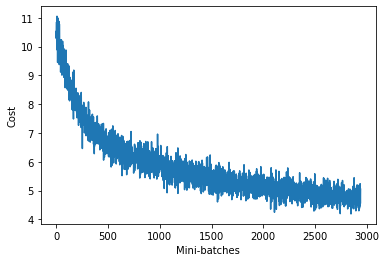

In [5]:
# PLAYING WITH HYPERPARAMETERS

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = torchvision.datasets.CIFAR10('/content/sample_data/', download=True, transform=transform)

mlp = TwoLayerMLP(hidden_activation='sigmoid', n_epochs=15, batch_size=256, verbose=True, learning_rate=0.005, hidden_layer_width=100)
mlp.train(train_dataset)
plt.plot(mlp.cost)
plt.ylabel('Cost')
plt.xlabel('Mini-batches')
# test_dataset = torchvision.datasets.CIFAR10('/content/sample_data/', download=True, train=False, transform=transform)
# mlp.test(test_dataset)

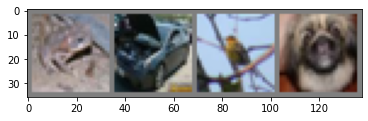

 frog   car  bird   dog


In [0]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def image_show(img):
  img = img/2 + 0.5
  np_img = img.numpy()
  plt.imshow(np.transpose(np_img, (1, 2, 0)))
  plt.show()

# data_iter = iter(train_loader)
images, labels = iter(train_loader).next()

image_show(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4))) 